### Basic imports (TODO: move to a python file?)

In [1]:
import pickle
from diffusion.likelihood import mmff_energy
#from rdkit.Chem.Draw import IPythonConsole
#IPythonConsole.ipython_useSVG=True 
import py3Dmol
from rdkit import Chem, Geometry
#from ipywidgets import interact, Dropdown
import matplotlib.pyplot as plt
from rdkit.Chem import rdMolAlign 
#from termcolor import colored 
from rdkit.Chem import rdMolTransforms
from utils.standardization import fast_rmsd
from torch_geometric.data import Data, Batch
import tqdm 
from torch.utils.data import Subset 
import time 

#from diffusion.sampling import get_seed, embed_seeds
from utils.dataset import *
#from gflownet.make_eval_plots import get_2dheatmap_array_and_pt 
from utils.torsion import get_rotatable_ta_list 
import pandas as pd

/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch_geometric/typing.py:99: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch_spline_conv/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(
/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [2]:
def set_bond_lengths(mol, ref_mol):
    new_mol = copy.deepcopy(mol)
    assert new_mol.GetNumConformers() == 1    
    for bond in mol.GetBonds():
        if bond.IsInRing() == False:
            new_bond_length = rdMolTransforms.GetBondLength(ref_mol.GetConformer(),bond.GetBeginAtom().GetIdx(), bond.GetEndAtom().GetIdx() )
            rdMolTransforms.SetBondLength(new_mol.GetConformer(), bond.GetBeginAtom().GetIdx(), bond.GetEndAtom().GetIdx(), new_bond_length )
    return new_mol

def set_bond_angles(mol, ref_mol):
    new_mol = copy.deepcopy(mol)
    assert mol.GetNumConformers() == 1
    for bond in mol.GetBonds():
        atom1 = bond.GetBeginAtom()
        atom2 = bond.GetEndAtom()
        for neighbor in atom2.GetNeighbors():
            if neighbor.GetIdx() != atom1.GetIdx():
                if not (atom1.IsInRing() and atom2.IsInRing() and neighbor.IsInRing() ):
                    new_angle = rdMolTransforms.GetAngleRad(ref_mol.GetConformer(),   
                                                        atom1.GetIdx(), 
                                                        atom2.GetIdx(), 
                                                        neighbor.GetIdx())
                    rdMolTransforms.SetAngleRad(new_mol.GetConformer(),   
                                                        atom1.GetIdx(), 
                                                        atom2.GetIdx(), 
                                                        neighbor.GetIdx(), new_angle)
    return new_mol

In [3]:
def plot_confs(mols, align = True):
    #for conf in data:
        #mol = pyg_to_mol(conf.mol, conf, mmff=False, rmsd=False, copy=True)
        #mols.append(mol)
    # align all mols to the first one
    if align:
        for i in range(1, len(mols)):
            rdMolAlign.AlignMol(mols[i], mols[0])
    # Plot mols
    ## Convert to mol blocks
    mol_blocks = [Chem.MolToMolBlock(mol) for mol in mols]

    colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta', 'pink', 'brown', 'grey', 'black', 'white', 'salmon', 'olive', 'lime', 'teal', 'indigo', 'violet', 'tan', 'khaki', 'gold', 'coral', 'azure', 'lavender', 'orchid', 'plum', 'crimson', 'maroon', 'sienna', 'navy', 'skyblue', 'turquoise', 'aquamarine', 'mint', 'lime', 'chartreuse', 'olive', 'khaki', 'gold', 'coral', 'salmon', 'tomato', 'orangered', 'firebrick', 'maroon', 'sienna', 'chocolate', 'saddlebrown', 'brown', 'black', 'grey', 'dimgray', 'darkgray', 'silver', 'lightgray', 'gainsboro', 'white']
    view = py3Dmol.view(width=400, height=400)
    for i, mol_block in enumerate(mol_blocks):
        view.addModel(mol_block, "mol")
        view.setStyle({'model': i}, {'stick': {'color': colors[i%len(colors)]}})

    view.addLabel('confs',{'position': {'x': 0, 'y': 8, 'z': 0}, 
                'backgroundColor': 'white', 
                'fontColor': 'black', 
                'fontSize': 16, 
                'alignment': 'topCenter'})
    view.zoomTo()
    view.show()

In [4]:
def get_rmsd_torsiondist(data,ix0, ix1):
    '''
    Get 2D rmsd heatmap and 2D torsion_angles dists heatmap
    '''
    torsion_angles_linspace = torch.linspace(0, 2*np.pi, 100)
    rmsds = []
    torsion_angles_dists = []
    for theta0 in torsion_angles_linspace:
        rmsds.append([])
        torsion_angles_dists.append([])
        for theta1 in torsion_angles_linspace:
            data0 = copy.deepcopy(data)
            torsion_update = np.zeros(len(data0.mask_rotate))
            torsion_update[ix0], torsion_update[ix1] = theta0, theta1
            new_pos = modify_conformer(data0.pos, data0.edge_index.T[data0.edge_mask], data0.mask_rotate, torsion_update, as_numpy=False) #change the value of the 1st torsion angle
            data0.pos = new_pos
            mol0 = pyg_to_mol(data0.mol, data0, mmff=False, rmsd=True, copy=True)
            mol = pyg_to_mol(data.mol, data, mmff=False, rmsd=True, copy=True)
            rmsds[-1].append(fast_rmsd(mol0, mol, conf1=0, conf2=0))
            torsion_angles_dists[-1].append(min(theta1, 2 * np.pi - theta1) + min(theta0, 2 * np.pi - theta0))  
            
    return rmsds, torsion_angles_dists

In [5]:
def embed_func(mol, numConfs):
    AllChem.EmbedMultipleConfs(mol, numConfs=numConfs, numThreads=5)
    return mol

In [6]:
def set_positions(mol, positions):
    new_mol = copy.deepcopy(mol)
    for atom_idx, pos in enumerate(positions):
        new_mol.GetConformer().SetAtomPosition(atom_idx, Geometry.Point3D(pos[0], pos[1], pos[2]))
    return new_mol

In [7]:
def intrinsic_to_extrinsic_coords(mol, bond_lengths, bond_angles, torsion_angles ):
    '''
    Given a list of bond lengths, bond angles and torsion angles, obtained using rdMolTransforms, this function gives back the 3D coordinates of a molecule
    '''
    

### Explore freesolv

In [8]:
freesolv_df = pd.read_csv('data/freesolv_79smis_1_confs.csv')
freesolv_df = freesolv_df[~freesolv_df['smiles'].isin([ ' c1cc(ccc1[N+](=O)[O-])O', ' CC[C@@H](C)CO' , ' C[C@@H](CO[N+](=O)[O-])O[N+](=O)[O-]' , ' CCCC[N+](=O)[O-]', ' CC(=O)CO[N+](=O)[O-]', ' Cc1cccc(c1)[N+](=O)[O-]', ' CC[N+](=O)[O-]', ' CCOP(=S)(OCC)S[C@@H](CCl)N1C(=O)c2ccccc2C1=O',
 ' CCOP(=S)(OCC)Oc1ccc(cc1)[N+](=O)[O-]',
 ' CCCC[N@](CC)c1c(cc(cc1[N+](=O)[O-])C(F)(F)F)[N+](=O)[O-]',
 ' CCOC(=O)C[C@H](C(=O)OCC)SP(=S)(OC)OC',
 ' CCN(CC)c1c(cc(c(c1[N+](=O)[O-])N)C(F)(F)F)[N+](=O)[O-]',
 ' CCCN(CCC)c1c(cc(cc1[N+](=O)[O-])S(=O)(=O)C)[N+](=O)[O-]',
 ' CCCN(CCC)c1c(cc(cc1[N+](=O)[O-])C(F)(F)F)[N+](=O)[O-]'
 ])]
# remove some smiles cause they don't have md simulation
limit_mols = 72
smis_train, smis_test = list(set(freesolv_df['smiles'].tolist()))[:limit_mols], list(set(freesolv_df['smiles'].tolist()))[limit_mols:]
smis_train, smis_test = [x[1:] for x in smis_train], [x[1:] for x in smis_test] # Remove the first empty space in the smiles names
print('len of dataset, ' , len(smis_train), len(smis_test))

len of dataset,  72 0


In [9]:
' '.join(smis_train)

'c1ccc(cc1)O[C@@H](C(F)F)F CC(C)CCO CCOCCO CC(=C)C=C CC(=O)OCC(COC(=O)C)OC(=O)C CC(C)COC(=O)C CCCCCCN CCCCCBr CC(C)C=C CC=C(C)C CC(=CCC/C(=C\\CO)/C)C CCc1cccc(c1)O CC[C@H](C(C)C)O CCC(C)CC COc1ccccc1 CC(C)OC(C)C COC(=O)C(F)(F)F CCCCC(=O)OCC CCC CC(C)(C)C CCOC(=O)c1ccc(cc1)O CCOC(=O)CCC(=O)OCC CCOP(=O)(OCC)OCC CCCC(C)(C)C CCc1cccc2c1cccc2 CCCc1ccccc1 C1C=CC[C@@H]2[C@@H]1C(=O)N(C2=O)SC(Cl)(Cl)Cl CC(C)(C)C(=O)OC CC[C@H](C)c1ccccc1 c1ccc2c(c1)C(=O)c3c(ccc(c3C2=O)N)N COc1cccc(c1O)OC CCCCCCl CCCCCCCC(=O)C CCCCOCCCC CC(C)CCOC=O COc1ccccc1OC C[C@@H]1CCCC[C@@H]1C Cn1cnc2c1c(=O)n(c(=O)n2C)C CCCCCCCC(=O)OC CCCCCCC Cc1cccc(c1C)O CCOP(=S)(OCC)SCSCC CC(C)(C)Br C[C@H](CC(C)C)O CN(C)C(=O)Nc1ccccc1 CCC[C@@H](C)O CC(=CCC/C(=C/CO)/C)C C1[C@H]([C@@H]([C@H]([C@H](O1)O)O)O)O COCC(OC)(OC)OC CCSC c1ccc(cc1)CCCO CCCc1ccc(c(c1)OC)O CC(=C)c1ccccc1 CCCCCCCCC=O CCCCCCBr CCOC(=O)c1ccccc1 COC=O CC(C)O CC(C)c1ccccc1 CCCOCCC CC(C)CO COc1ccccc1N c1cc(cc(c1)O)C#N Cc1cc2ccccc2cc1C c1ccc(c(c1)C(F)(F)F)C(F)(F)F COC(OC)OC C

In [10]:
def get_info(smis):
    num_heavy_atoms = [] 
    num_atoms = [] 
    num_torsion_angles = [] 
    valid_smis = []
    min_n_torsion = 1
    for smi in tqdm.tqdm(smis): 
        mol, data = get_seed(smi)
        if mol is None:
            pass
        #elif hasattr(data, 'mask_rotate') == False or data.mask_rotate.shape[0] < min_n_torsion:
        elif len(get_rotatable_ta_list(mol)) < min_n_torsion:
                pass
        else:
            num_heavy_atoms.append(mol.GetNumHeavyAtoms())
            num_atoms.append(mol.GetNumAtoms())
            num_torsion_angles.append(len(get_rotatable_ta_list(mol)))
            valid_smis.append(smi)

    num_heavy_atoms, num_atoms, num_torsion_angles = np.array(num_heavy_atoms), np.array(num_atoms), np.array(num_torsion_angles)
    valid_smis = np.array(valid_smis)
    print(f'Processable smiles: {len(valid_smis)} out of {len(smis)}')
    return num_heavy_atoms, num_atoms, num_torsion_angles, valid_smis


num_heavy_atoms, num_atoms, num_torsion_angles, valid_smis = get_info(smis_train)
smis_with_2_tas = np.array(valid_smis)[np.where(num_torsion_angles == 2)]



100%|██████████| 72/72 [00:00<00:00, 148.59it/s]

Processable smiles: 72 out of 72


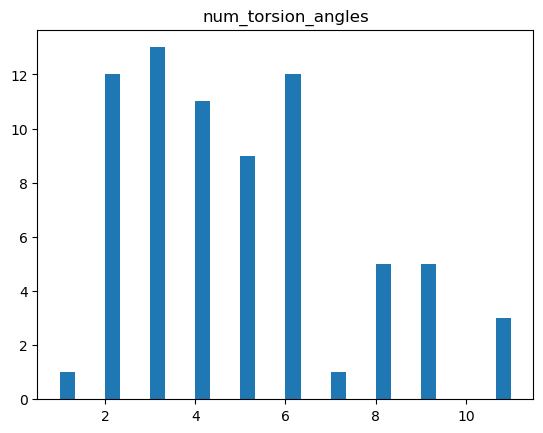

In [11]:
plt.hist(num_torsion_angles, bins=30)
plt.title("num_torsion_angles")
plt.show()

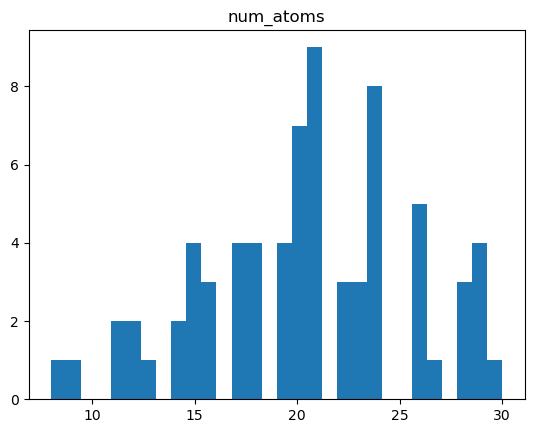

In [12]:
plt.hist(num_atoms, bins=30)
plt.title("num_atoms")
plt.show()

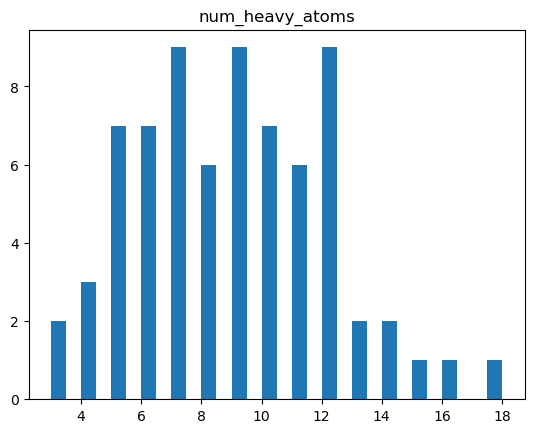

In [13]:
plt.hist(num_heavy_atoms, bins=30)
plt.title("num_heavy_atoms")
plt.show()

In [14]:
'''
k_b = 0.001987204118 
room_temp = 298.15
T = k_b * room_temp

md_trajs_dict = pickle.load(open('/home/mila/l/lena-nehale.ezzine/ai4mols/torsional-diffusion/data/mdtrajs_dict_reordered.pkl', 'rb'))
not_valid_smis = []
pos_md = {key[1:]: value for  key, value in md_trajs_dict.items()}
logrews_md = {key[1:]: [] for  key, value in md_trajs_dict.items()}
mols_md  = {key[1:]: [] for  key, value in md_trajs_dict.items()}
for smi in tqdm.tqdm(list(mols_md.keys())):
    try:
        mol, data = get_seed(smi)
        AllChem.EmbedMultipleConfs(mol, numConfs=1)
        try: 
            for i in range(len(pos_md[smi])):
                pos = pos_md[smi][i]
                assert len(10 * pos.astype('double')) == mol.GetNumAtoms()
                new_mol = set_positions(mol,10 * pos.astype('double'))
                mols_md[smi].append(new_mol) 
                logrews_md[smi].append( - mmff_energy(new_mol) / T)
        except:
            print('error')
    except:
        print('smi ', smi)
        not_valid_smis.append(smi)

for smi in  not_valid_smis:
    del logrews_md[smi]
    del mols_md[smi]
    del pos_md[smi]
    
pickle.dump(logrews_md, open('data/logrews_md.pkl', 'wb'))
pickle.dump(mols_md, open('data/mols_md.pkl', 'wb'))
pickle.dump(pos_md, open('data/pos_md.pkl', 'wb'))
'''

"\nk_b = 0.001987204118 \nroom_temp = 298.15\nT = k_b * room_temp\n\nmd_trajs_dict = pickle.load(open('/home/mila/l/lena-nehale.ezzine/ai4mols/torsional-diffusion/data/mdtrajs_dict_reordered.pkl', 'rb'))\nnot_valid_smis = []\npos_md = {key[1:]: value for  key, value in md_trajs_dict.items()}\nlogrews_md = {key[1:]: [] for  key, value in md_trajs_dict.items()}\nmols_md  = {key[1:]: [] for  key, value in md_trajs_dict.items()}\nfor smi in tqdm.tqdm(list(mols_md.keys())):\n    try:\n        mol, data = get_seed(smi)\n        AllChem.EmbedMultipleConfs(mol, numConfs=1)\n        try: \n            for i in range(len(pos_md[smi])):\n                pos = pos_md[smi][i]\n                assert len(10 * pos.astype('double')) == mol.GetNumAtoms()\n                new_mol = set_positions(mol,10 * pos.astype('double'))\n                mols_md[smi].append(new_mol) \n                logrews_md[smi].append( - mmff_energy(new_mol) / T)\n        except:\n            print('error')\n    except:\n     

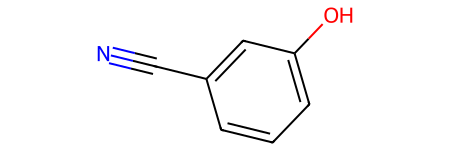

In [15]:
Chem.MolFromSmiles(' c1cc(cc(c1)O)C#N')

In [16]:
set(freesolv_df["smiles"].tolist())

{' C([C@H]([C@H]([C@@H]([C@@H](CO)O)O)O)O)O',
 ' C1C=CC[C@@H]2[C@@H]1C(=O)N(C2=O)SC(Cl)(Cl)Cl',
 ' C1[C@H]([C@@H]([C@H]([C@H](O1)O)O)O)O',
 ' CC(=C)C=C',
 ' CC(=C)c1ccccc1',
 ' CC(=CCC/C(=C/CO)/C)C',
 ' CC(=CCC/C(=C\\CO)/C)C',
 ' CC(=O)OCC(COC(=O)C)OC(=O)C',
 ' CC(=O)Oc1ccccc1C(=O)O',
 ' CC(C)(/C=N\\OC(=O)NC)SC',
 ' CC(C)(C)Br',
 ' CC(C)(C)C',
 ' CC(C)(C)C(=O)OC',
 ' CC(C)C=C',
 ' CC(C)CCO',
 ' CC(C)CCOC=O',
 ' CC(C)CO',
 ' CC(C)COC(=O)C',
 ' CC(C)O',
 ' CC(C)OC(C)C',
 ' CC(C)c1ccccc1',
 ' CC=C(C)C',
 ' CCC',
 ' CCC(C)CC',
 ' CCCC(C)(C)C',
 ' CCCCC(=O)OCC',
 ' CCCCC=O',
 ' CCCCCBr',
 ' CCCCCCBr',
 ' CCCCCCC',
 ' CCCCCCCC(=O)C',
 ' CCCCCCCC(=O)OC',
 ' CCCCCCCCC=O',
 ' CCCCCCN',
 ' CCCCCCl',
 ' CCCCOCCCC',
 ' CCCOCCC',
 ' CCC[C@@H](C)O',
 ' CCCc1ccc(c(c1)OC)O',
 ' CCCc1ccccc1',
 ' CCOC(=O)CCC(=O)OCC',
 ' CCOC(=O)c1ccc(cc1)O',
 ' CCOC(=O)c1ccccc1',
 ' CCOCCO',
 ' CCOP(=O)(OCC)OCC',
 ' CCOP(=S)(OCC)SCSCC',
 ' CCS',
 ' CCSC',
 ' CC[C@H](C(C)C)O',
 ' CC[C@H](C)O',
 ' CC[C@H](C)c1ccccc1',
 ' 

### FreeSolv eval plots

In this section, we define functions for making a histogram of energies, tica plots, and histograms distribution of bond lengths/bond angles/torsion angles/ visualizing energy plots vs logpT plots

In [8]:
## general model params
device = torch.device('cuda')
sigma_min = 0.01 * np.pi
sigma_max = np.pi
## energy params
energy_fn = 'mmff'
seed = 76
k_b = 0.001987204118 
room_temp = 298.15
T = k_b * room_temp
logrew_clamp = -1e5
n_smis_batch = 1
energy_fn, seed, p_replay, p_expl, diffusion_steps, batch_size = 'mmff', 0, 0.0, 0.0, 20, 32 
smis = "C1C=CC[C@@H]2[C@@H]1C(=O)N(C2=O)SC(Cl)(Cl)Cl  COC=O  c1ccc2c(c1)C(=O)c3c(ccc(c3C2=O)N)N".split()
#smis = "CCS".split()
limit_train_mols = len(smis) 
n_local_structures = 1
max_n_local_structures = 1
train_mode = 'gflownet' 
use_synthetic_aug = False
init_positions_path = "/home/mila/l/lena-nehale.ezzine/ai4mols/torsional-diffusion/data/md_trajs_dict.pkl"


In [9]:
from gflownet.make_eval_plots import *


exp_path = f"{train_mode}_{energy_fn}_{seed}_limit_train_mols_{limit_train_mols}_p_replay_{p_replay}_p_expl_{p_expl}_diffusion_steps_{diffusion_steps}_max_n_local_structures_{max_n_local_structures}_use_synthetic_aug_{use_synthetic_aug}"
if limit_train_mols == 1 : 
    exp_path += f"_smi_{smis[0]}" 
model = load_model(exp_path, device)

generated_stuff = generate_stuff(model, smis, n_smis_batch, batch_size, diffusion_steps, T, logrew_clamp, energy_fn, device, sigma_min, sigma_max, init_positions_path = init_positions_path, n_local_structures = n_local_structures, max_n_local_structures = max_n_local_structures, train_mode = 'gflownet')
torch.cuda.empty_cache()



/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type anno

smis subset ['C1C=CC[C@@H]2[C@@H]1C(=O)N(C2=O)SC(Cl)(Cl)Cl']
smis subset ['COC=O']
smis subset ['c1ccc2c(c1)C(=O)c3c(ccc(c3C2=O)N)N']


0 0


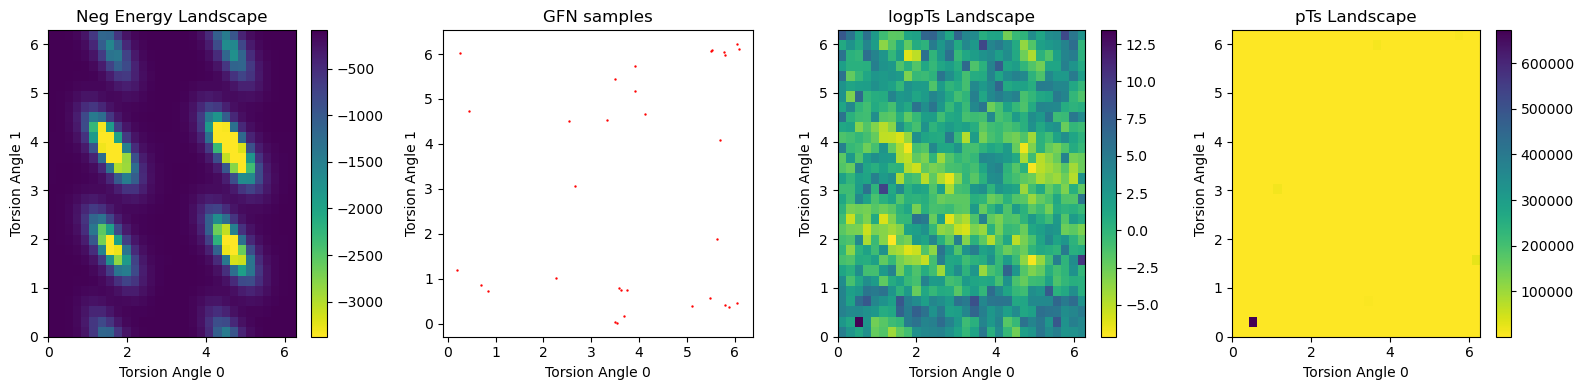

0 0


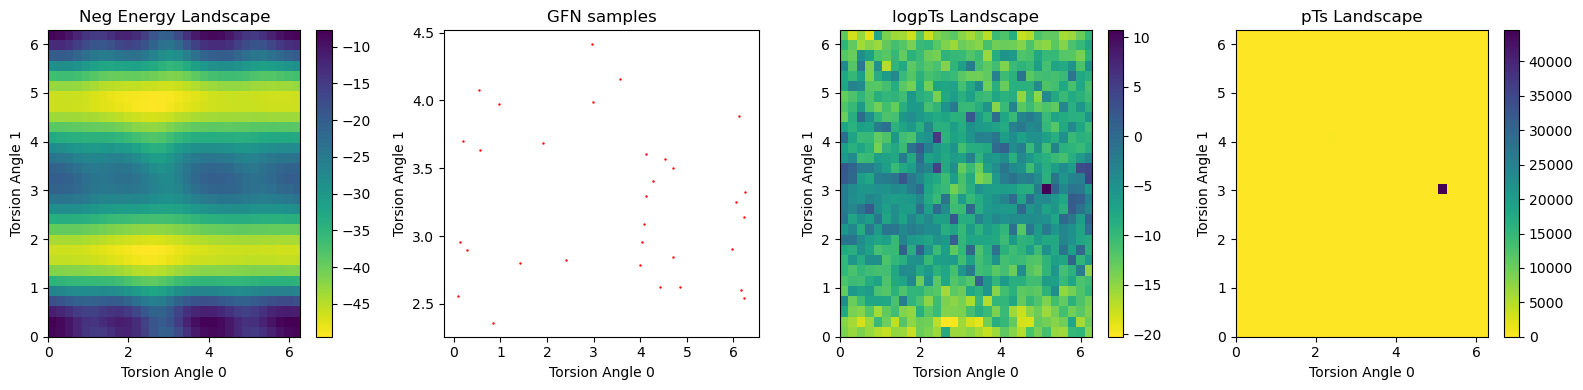

0 0


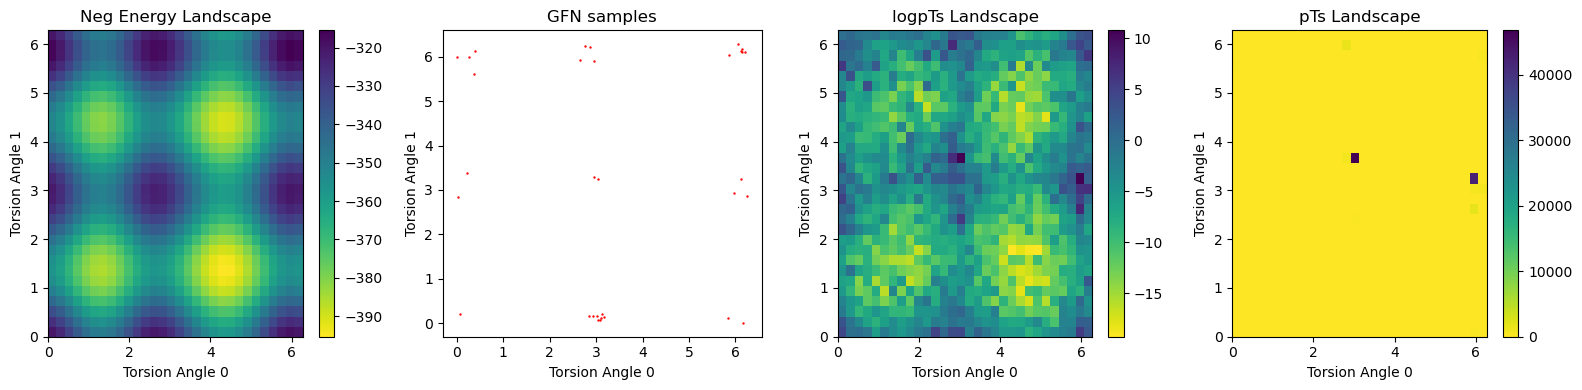

In [ ]:
steps = 20
num_points = 30
num_trajs = 16
plot_energy_landscape = True
plot_pt = True 
plot_sampled_confs = True 

plot_energy_samples_logpTs(model, smis, generated_stuff, energy_fn, init_positions_path, n_local_structures, max_n_local_structures, sigma_min, sigma_max,  steps, device, num_points, num_trajs, T,  plot_energy_landscape, plot_sampled_confs, plot_pt, use_wandb  = False, path = None )

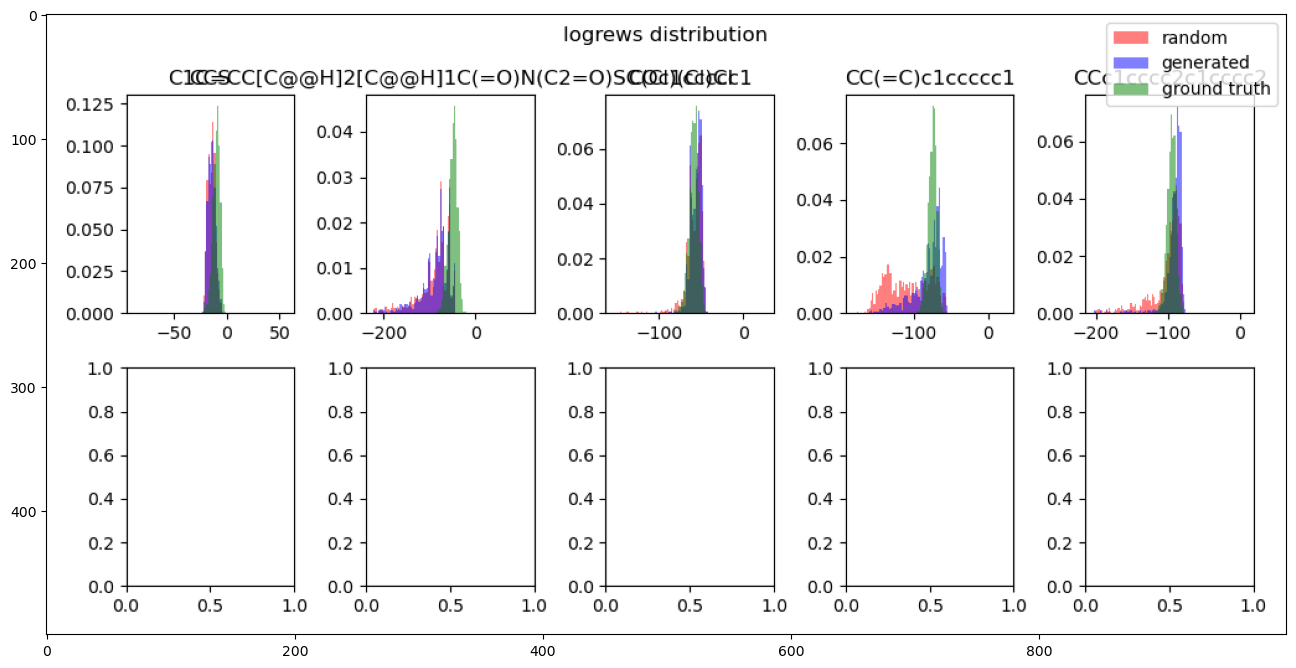

In [ ]:
make_logrew_histograms(generated_stuff, exp_path, label = 'train', range = 2)
make_localstructures_histograms(generated_stuff, exp_path, label = 'train')
img_path = "/home/mila/l/lena-nehale.ezzine/scratch/torsionalGFN/logrew_hist/gflownet_mmff_0_limit_train_mols_5_p_replay_0.0_p_expl_0.0_diffusion_steps_20_max_n_local_structures_10_use_synthetic_aug_False_train.png"
img = plt.imread(img_path)
plt.figure(figsize=(16,10))
plt.imshow(img)

In [16]:
# Giffy Gifs
seed = 76
n_mols = 1
smi = "C1C=CC[C@@H]2[C@@H]1C(=O)N(C2=O)SC(Cl)(Cl)Cl"
#smi = "COC=O"
#smi = "c1ccc2c(c1)C(=O)c3c(ccc(c3C2=O)N)N"
p_expl = 0.2
p_replay = 0.0
lr = 0.001
#T = 0.5924849077817
for T in [0.1, 0.59, 1.0, 10, 100]:
    import imageio
    from os import listdir
    img_directory = "/home/mila/l/lena-nehale.ezzine/scratch/torsionalGFN/gfn_samples/"
    images = []
    filenames = [f for f in listdir(img_directory) if f.endswith('.png') and f'_{seed}_' in f and f'n_mols_{n_mols}' in f and smi in f and f"p_expl_{p_expl}" in f and f"p_replay_{p_replay}" in f and f"lr_{lr}" in f and f"T_{T}" in f ]
    for filename in filenames:
        images.append(imageio.imread(img_directory + filename))

    if not os.path.exists("gifs"):
        os.makedirs("gifs")
    imageio.mimsave(f'gifs/n_mols_{n_mols}_{smi}_p_expl_{p_expl}_p_replay_{p_replay}_lr_{lr}_T_{T}_seed_{seed}.gif', images)

/tmp/ipykernel_545333/455001546.py:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(img_directory + filename))


### Euclidean RMSD vs torsional RMSD

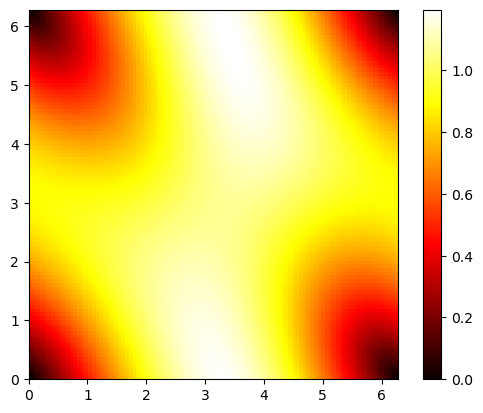

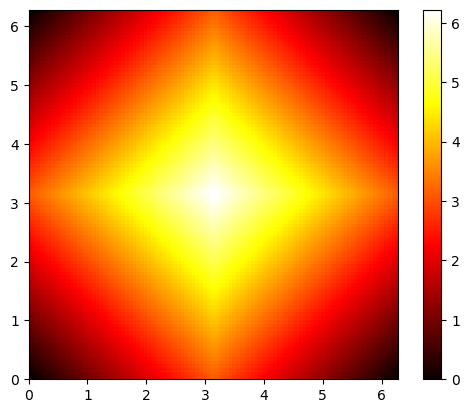

In [31]:
smi =  'COc1ccccc1'
data = make_dataset_from_smi([smi], init_positions_path= "/home/mila/l/lena-nehale.ezzine/ai4mols/torsional-diffusion/data/md_trajs_dict.pkl" , n_local_structures = 1)[0][0]
rmsds,torsion_angles_dists  = get_rmsd_torsiondist(data , ix0 = 0, ix1 = 1)
plt.figure() 
plt.imshow(rmsds, extent=(0, 2*np.pi, 0, 2*np.pi), origin='lower', cmap='hot', interpolation='nearest')
plt.colorbar()
plt.figure()
plt.imshow(torsion_angles_dists, extent=(0, 2*np.pi, 0, 2*np.pi), origin='lower', cmap='hot', interpolation='nearest')
plt.colorbar()

### Distributional shift(ground truth/ rdkit-generated data/ rdkit-generated data after confs matching) in bond lengths/bond angles 

In [25]:
ix_smi = 0
datapoint = dataset.datapoints[ix_smi]
data = copy.deepcopy(datapoint)
mols = []
for ix in range(len(data.pos)):
    data.pos, data.weights = datapoint.pos[ix], datapoint.weights[ix]
    mol = pyg_to_mol(data.mol, data, mmff=False, rmsd=True, copy=True)
    mols.append(mol)

get_stds_internal_coords(mols)

(tensor(0.0150), tensor(0.0328), tensor(1.5765))

In [9]:
mols_gen = list(conformers_gen.values())[0]
get_stds_internal_coords(mols_gen)

(tensor(0.0159), tensor(0.0701), tensor(1.5332))

In [10]:
bond_angles = [get_bond_angles(mol) for mol in mols]
bond_angles_gen = [get_bond_angles(mol)[:-1] for mol in mols_gen]
torch.stack(bond_angles + bond_angles_gen).std(dim=0).mean()

tensor(0.1286)

In [11]:
bond_lengths = [get_bond_lengths(mol) for mol in mols]
bond_lengths_gen = [get_bond_lengths(mol) for mol in mols_gen]
torch.stack(bond_lengths + bond_lengths_gen).std(dim=0).mean()

tensor(0.0986)

Hm, the std deviation of bond lengths&bond angles increases when we concatenate [mols_ground truth, mols_gen]. which seems to indicate a distributional shift in the lengths/angles distributions when we are moving from gt to rdkit-generated. Does this explain the energy-shifts?

Hmmmm, interesting, the torsion angles change a lot with relaxation. But why does relaxation need to go so far in terms of RMSD? Why doesn't it go to the closest 'ground-truth' conformer?

Well, if we look at the eval metrics for this set of molecules: 

 - threshold 0.75:

- Recall Coverage: Mean = 61.66, Median = 82.02

- Recall AMR: Mean = 0.6300, Median = 0.5793

- Precision Coverage: Mean = 35.80, Median = 42.31

- Precision AMR: Mean = 0.9013, Median = 0.7905

The precision AMR is around 0.9, i.e. it is the same order of magnitude of relaxtion. So the results with relaxation are not that surprising


**Training conformers after conformer matching have low energy!** Ca laisse penser que c'est le modele qui est pas assez bon

        - Plot : bond lengths and angles distribution of training conformers after confs matching. Ot has very low variance, so it makes sense to fix bond lengths/angles, and it's the diff model that is pretty bad
       
        - How does this energy compare to the energy of conformers **before confs matching?** -> voir si ça vaut vraiment le coup de fixer les bond lengths/angles ou pas

### Impact of fixing the bond lengths/angles on the energy

In [ ]:
import random

all_energies_before = []
all_energies_after = []

for smi_idx in tqdm(range(len(dataset))): 
#random.sample(range(0, len(dataset)), n_smis)
#for smi_idx in range(0, n_smis):   
    confs = get_gt_confs(dataset, smi_idx)
    mols = [pyg_to_mol(conf.mol, conf, mmff=False, rmsd=False, copy=True) for conf in confs]
    energies_before = [mmff_energy(mol) for mol in mols]
    energies_after = []
    for mol in mols:
        mol = set_bond_lengths(mol, mols[-1])
        mol = set_bond_angles(mol, mols[-1])
        energies_after.append(mmff_energy(mol))
    all_energies_before.append(energies_before)
    all_energies_after.append(energies_after)


100%|██████████| 9295/9295 [13:56<00:00, 11.12it/s]


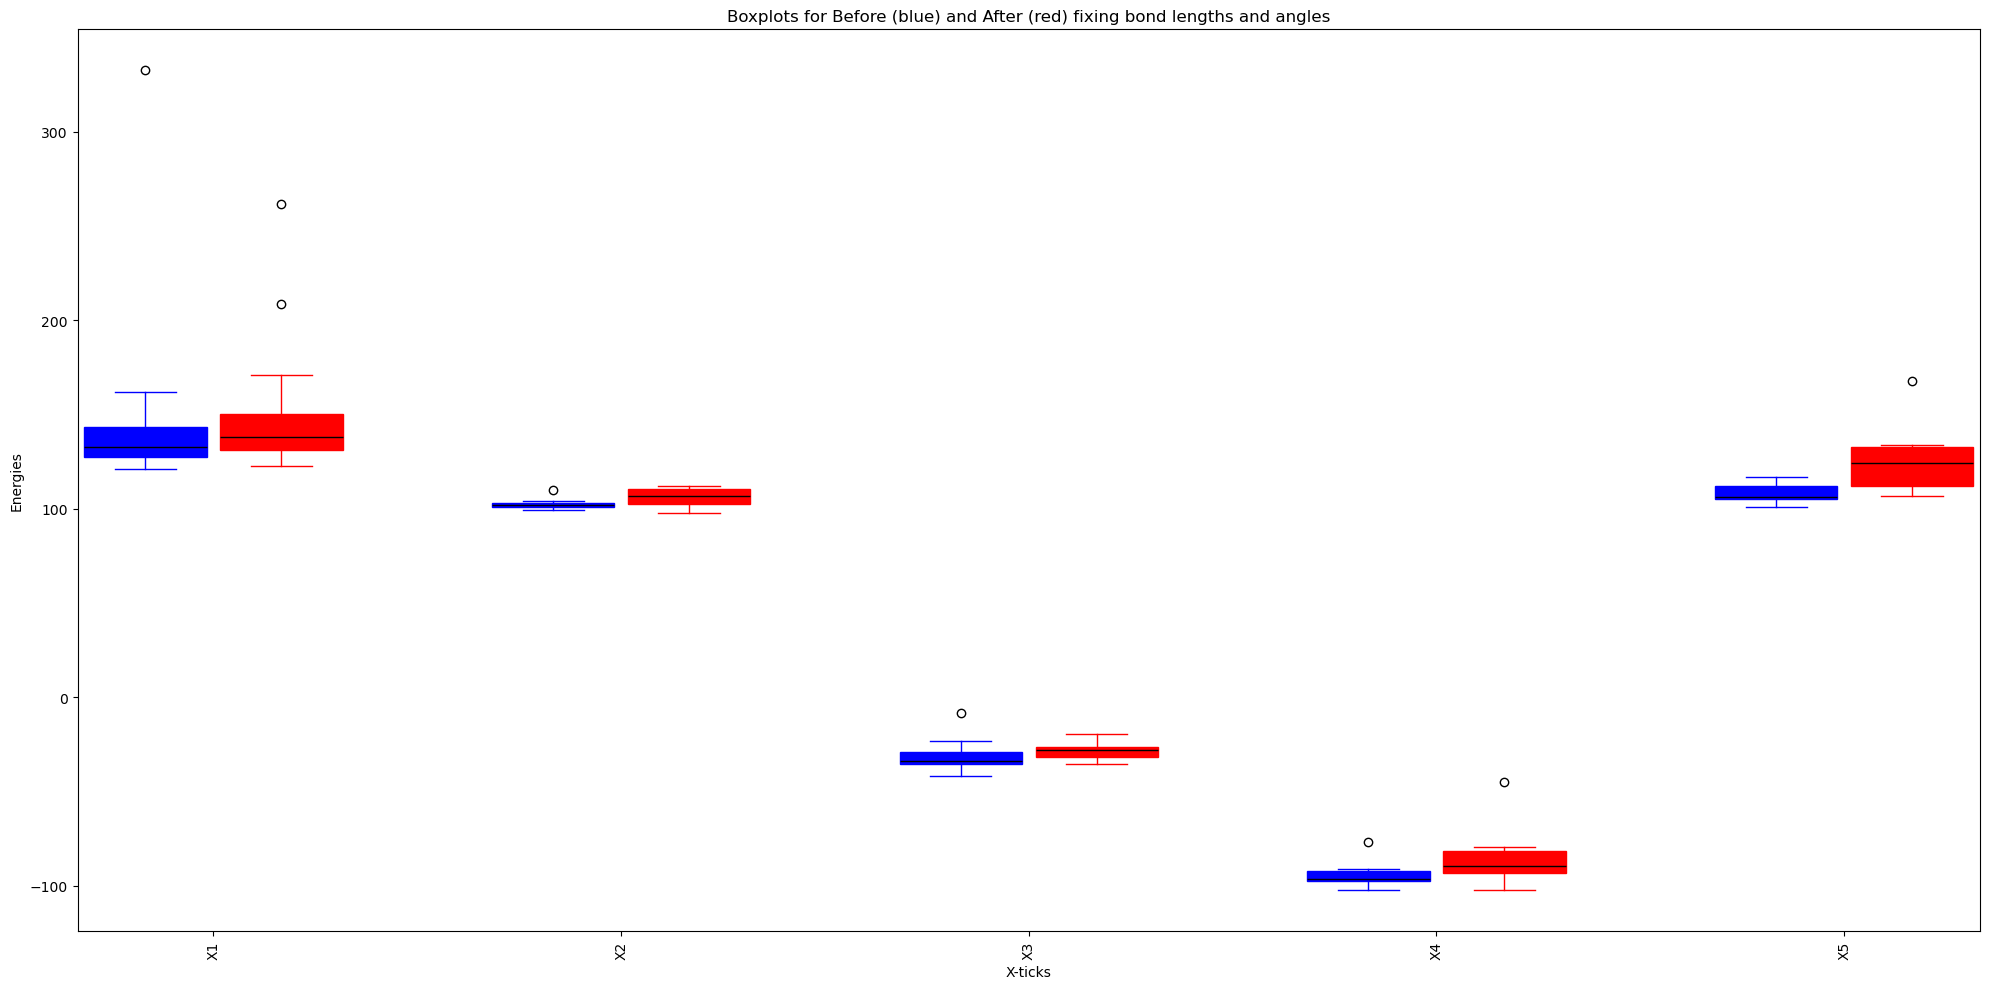

In [ ]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(20, 10))
n_smis = 5
# Plot the boxplots
positions = np.arange(1, 3* n_smis + 1, 3)  # Positions for 'before' boxplots
for i in range(n_smis):
    ax.boxplot(all_energies_before[i], positions=[positions[i]], widths=0.9,  patch_artist=True,
               boxprops=dict(facecolor='blue', color='blue'),
               medianprops=dict(color='black'),
               whiskerprops=dict(color='blue'),
               capprops=dict(color='blue'))

    ax.boxplot(all_energies_after[i], positions=[positions[i ] + 1], widths=0.9, patch_artist=True,
               boxprops=dict(facecolor='red', color='red'),
               medianprops=dict(color='black'),
               whiskerprops=dict(color='red'),
               capprops=dict(color='red'))

# Customize x-ticks
ax.set_xticks(positions + 0.5)
ax.set_xticklabels([f'X{i+1}' for i in range(n_smis)], rotation=90)

# Set labels and title
ax.set_xlabel('X-ticks')
ax.set_ylabel('Energies')
ax.set_title('Boxplots for Before (blue) and After (red) fixing bond lengths and angles')
# Display the plot
plt.tight_layout()
plt.show()

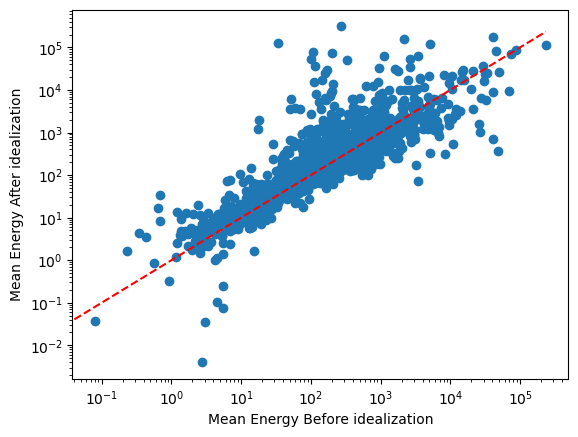

In [ ]:
energies_before_means = [np.mean(x) for x in all_energies_before]
energies_after_means = [np.mean(x) for x in all_energies_after]

plt.scatter(energies_before_means, energies_after_means)
plt.xlabel('Mean Energy Before idealization')
plt.ylabel('Mean Energy After idealization')
plt.xscale('log')

plt.plot([min(energies_before_means), max(energies_before_means)], 
         [min(energies_before_means), max(energies_before_means)], 
         color='red', linestyle='--')
plt.yscale('log')
plt.show()


TODO: after the deadline, look into outliers of this plot

### Correlation flaws & other metrics

In [ ]:
N = 100
c = 5
n_exps = 200
corrs0 = []
corrs1 = []
for _ in range(n_exps):
    # sample N 2D points from a std normal
    z = np.random.normal(0, 1, size=(N, 2)) 
    # compute correlation between x and y coordinates
    corr0 = np.corrcoef(z.T )[0,1]
    corrs0.append(corr0)
    z1 = np.concatenate((z, c* np.array([[1, 1]])), axis=0)
    corr1 = np.corrcoef(z1.T )[0,1] 
    corrs1.append(corr1)

plt.scatter(corrs0, corrs1)
plt.xlabel('corr0')
plt.ylabel('corr1')

plt.show()

### Idem code

In [ ]:
'''
def perturb_seeds(batch, sigma, uniform = False):
    # takes a batch and returns its perturbed version with a noise level of sigma

def get_idem_score(batch, sigmas, N = 50, T  ):
    #Supposes that all conformers are from the same smiles
'''
smi =  "COC=O"
sigma_min, sigma_max = 0.01 * np.pi, np.pi 

data = make_dataset_from_smi([smi], init_positions_path= "/home/mila/l/lena-nehale.ezzine/ai4mols/torsional-diffusion/data/md_trajs_dict.pkl" , n_local_structures = 32, max_n_local_structures = 32)[smi][0]
T = 10.0
N = 50
sigmas = np.exp(np.random.uniform(low=np.log(sigma_min), high=np.log(sigma_max)))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


from einops import reduce
from utils.mols_invariant_feats import get_torsion_angles

def get_SKs(xt, sigma, N, T, device, eps = 1e-4):
    '''
    returns SK(x_t) following equation 9 in (), 
    '''
    # sample x0|t ~ N(0, \sigma_t^2)
    x0_t = Batch.from_data_list([copy.deepcopy(xt) for _ in range(N)])
    torsion_updates = np.random.normal(loc=0.0, scale=sigma, size=x0_t.edge_mask.sum()) % (2 * np.pi)
    pos = perturb_batch(x0_t.cpu(), torsion_updates) 
    x0_t.pos = pos.to(device)
    # sample y0|t by perturbing the tas of x0|t with a tiny change in torsion angles
    y0_t = copy.deepcopy(x0_t)
    torsion_updates = np.random.normal(loc=0.0, scale=eps, size=y0_t.edge_mask.sum()) % (2 * np.pi)
    pos = perturb_batch(y0_t.cpu(), torsion_updates) 
    y0_t.pos = pos.to(device)
    # Compute energies and their grads
    energies, grads_3d, grads_tas = [], [], []
    for i in range (len(x0_t)):
        #print('pos', x0_t[i].pos) # print('torsion angles', get_torsion_angles(mol))
        mol = pyg_to_mol(x0_t[i].mol, x0_t[i], copy=True)
        energy, grad_3d = mmff_energy(mol, get_grad = True)
        energies.append(energy / T)
        grads_3d.append(grad_3d / T)
        mol1 = pyg_to_mol(y0_t[i].mol, y0_t[i], copy=True)
        grad_tas = 
    energies, grads = torch.Tensor(energies), torch.stack(grads)
    weights = torch.softmax(energies , 0)
    SK = grads * weights.unsqueeze(1)
    SK = reduce( SK , 'N dim -> dim', reduction='sum')
    return SK


### Local search 

In [8]:
exp_path =  'gflownet_mmff_98_n_mols_3_p_replay_0.0_p_expl_0.2_steps_20_max_n_local_structures_1_use_synthetic_aug_False_lr_0.001_T_0.5924849077817'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train = True
sigma_min, sigma_max = 0.01 * np.pi, np.pi 
steps = 20
p_expl = 0.0
sample_mode = False
from gflownet.make_eval_plots import load_model
model = load_model(exp_path, device)
step_start = None 




/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type anno

In [9]:
smi = "COC=O"
conformers_input = make_dataset_from_smi([smi], init_positions_path= "/home/mila/l/lena-nehale.ezzine/ai4mols/torsional-diffusion/data/md_trajs_dict.pkl" , n_local_structures = 8, max_n_local_structures = 1)[smi]
from gflownet.gfn_train import *

In [31]:
trajs , _ , _ = sample_forward_trajs(conformers_input, model, train, sigma_min, sigma_max,  steps, device, p_expl, sample_mode, step_start =0 , step_end = steps)
len(trajs)
k = np.random.randint(1, 4)
print('k', k)

k 2


In [32]:
subtraj_backward = sample_backward_trajs(Batch.to_data_list(trajs[-1]), sigma_min, sigma_max,  steps, device = device, step_start = steps - k , step_end = None)
subtraj_forward , _ , _ = sample_forward_trajs(Batch.to_data_list(subtraj_backward[0]), model, train, sigma_min, sigma_max,  steps, device, p_expl, sample_mode, step_start =steps - k , step_end = None)

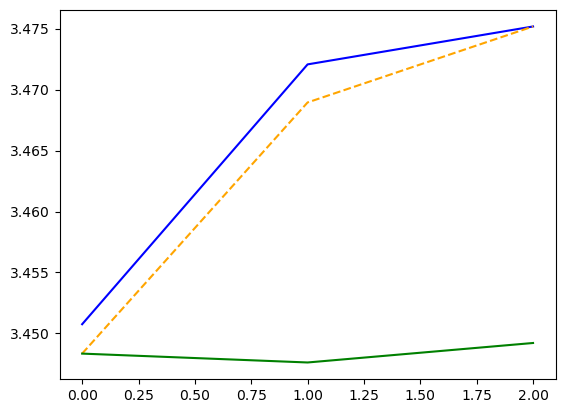

In [35]:
ix = np.random.randint(0, 16)
total_perturbs = np.array([x.total_perturb.cpu().numpy() for x in trajs])
plt.plot(total_perturbs[-k - 1:, ix:ix + 1], color = 'blue')
total_perturbs_backward = np.array([x.total_perturb.cpu().numpy() for x in subtraj_backward])
plt.plot(total_perturbs_backward[:,ix:ix + 1], color='orange', linestyle='--')
total_perturbs_forward = np.array([x.total_perturb.cpu().numpy() for x in subtraj_forward])
plt.plot(total_perturbs_forward[:,ix:ix + 1], color = 'green')
plt.show()

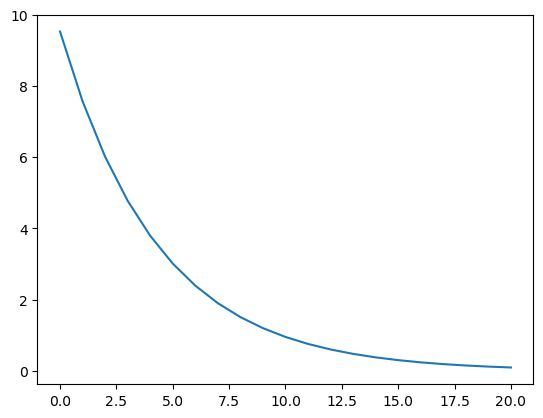

In [37]:
sigma_schedule = 10 ** np.linspace( np.log10(sigma_max), np.log10(sigma_min), steps + 1 )

g_schedule = sigma_schedule * np.sqrt(2 * np.log(sigma_max / sigma_min))

plt.plot(g_schedule)
plt.show()


In [ ]:
k = 4
trajs_root , _ , _ = sample_forward_trajs(conformers_input, model, train, sigma_min, sigma_max,  steps, device, p_expl, sample_mode, step_start =0 , step_end = steps - k)


trajs_leaf, _, _ = sample_forward_trajs(trajs_root[-1], model, train, sigma_min, sigma_max,  steps, device, p_expl, sample_mode, step_start = steps - k , step_end = steps )


In [ ]:
Batch.to_data_list(trajs_root[-1]) 

#duplicate a list



[Data(x=[8, 74], edge_index=[2, 14], edge_attr=[14, 4], z=[8], canonical_smi='COC=O', edge_mask=[14], mask_rotate=[2, 8], pos=[8, 3], mol=<rdkit.Chem.rdchem.Mol object at 0x7fec20373970>, total_perturb=[2], local_structure_id=0),
 Data(x=[8, 74], edge_index=[2, 14], edge_attr=[14, 4], z=[8], canonical_smi='COC=O', edge_mask=[14], mask_rotate=[2, 8], pos=[8, 3], mol=<rdkit.Chem.rdchem.Mol object at 0x7fec203739e0>, total_perturb=[2], local_structure_id=0),
 Data(x=[8, 74], edge_index=[2, 14], edge_attr=[14, 4], z=[8], canonical_smi='COC=O', edge_mask=[14], mask_rotate=[2, 8], pos=[8, 3], mol=<rdkit.Chem.rdchem.Mol object at 0x7fec20373a50>, total_perturb=[2], local_structure_id=0),
 Data(x=[8, 74], edge_index=[2, 14], edge_attr=[14, 4], z=[8], canonical_smi='COC=O', edge_mask=[14], mask_rotate=[2, 8], pos=[8, 3], mol=<rdkit.Chem.rdchem.Mol object at 0x7fec20373ac0>, total_perturb=[2], local_structure_id=0),
 Data(x=[8, 74], edge_index=[2, 14], edge_attr=[14, 4], z=[8], canonical_smi='CO

In [61]:
[x.edge_sigma[0] for x in trajs_root[1:]]

[tensor(3.1416, device='cuda:0'),
 tensor(2.4955, device='cuda:0'),
 tensor(1.9822, device='cuda:0'),
 tensor(1.5745, device='cuda:0'),
 tensor(1.2507, device='cuda:0'),
 tensor(0.9935, device='cuda:0'),
 tensor(0.7891, device='cuda:0'),
 tensor(0.6268, device='cuda:0'),
 tensor(0.4979, device='cuda:0'),
 tensor(0.3955, device='cuda:0'),
 tensor(0.3142, device='cuda:0'),
 tensor(0.2495, device='cuda:0'),
 tensor(0.1982, device='cuda:0'),
 tensor(0.1575, device='cuda:0'),
 tensor(0.1251, device='cuda:0'),
 tensor(0.0993, device='cuda:0')]

In [62]:
[x.edge_sigma[0] for x in trajs_leaf]

[tensor(0.0993, device='cuda:0'),
 tensor(0.0789, device='cuda:0'),
 tensor(0.0627, device='cuda:0'),
 tensor(0.0498, device='cuda:0'),
 tensor(0.0396, device='cuda:0')]

In [50]:
len(trajs_root) +  len(trajs_leaf) - 1

21